In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from iminuit import Minuit
from iminuit.cost import LeastSquares

def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [88]:
with open('../../genIII_data/JLab/Beam/Beam-Cal.pkl', 'rb') as file:
    # Load the data from the pickle file
    beam_data = pickle.load(file)

with open('../../genIII_data/Sim/e+_2.5_5deg.pkl', 'rb') as file:
    # Load the data from the pickle file
    sim_data = pickle.load(file)
    
e_cut = 0.3

In [89]:
events_array = np.array(beam_data["events"])

# Find indices where all values are zero along the rows (i.e., across all events)
zero_indices = np.where(np.all(events_array == 0.0, axis=0))[0]

# Convert to list if needed
zero_indices_list = zero_indices.tolist()

# Extract the board/ch pairs from the beam data
beam_positions = np.array(beam_data["positions"])
zero_positions = beam_positions[zero_indices_list]
beam_board_ch = zero_positions[:, [-2, -1]]  # columns 3 and 4: board num, ch_in_brd num

# Extract board/ch pairs from sim data
sim_positions = np.array(sim_data["positions"])
sim_board_ch = sim_positions[:, [-2, -1]]

# Find matching indices in sim_data
matching_indices = []

for pair in beam_board_ch:
    matches = np.where((sim_board_ch == pair).all(axis=1))[0]
    if len(matches) > 0:
        matching_indices.append(matches[0])  # or append all with .extend(matches)

sim_data["events"] = np.array(sim_data["events"])
sim_data["events"][:, matching_indices] = 0

In [90]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2. * sigma ** 2))

def layer_energy_sums(data, target_layer):
    positions = np.array(data['positions'])  # shape: (num_channels, 5)
    events = data['events']        # shape: (num_events,), each item: (num_channels,)

    layer_mask = positions[:, 3] == target_layer  # index 3 is 'layer'

    # For each event, apply the layer mask and threshold
    return np.array([
        event[layer_mask][event[layer_mask] > e_cut].sum()
        for event in events
    ])

def layer_energy_counts(data, target_layer):
    positions = np.array(data['positions'])  # shape: (num_channels, 5)
    events = data['events']  # shape: (num_events,), each item: (num_channels,)

    layer_mask = positions[:, 3] == target_layer  # index 3 is 'layer'

    # For each event, count how many values in the target layer are > e_cut
    return np.array([
        np.sum(event[layer_mask] > e_cut)
        for event in events
    ])

def channel_energy_values(data, target_layer, target_channel):
    positions = np.array(data['positions'])  # shape: (num_channels, 5)
    events = data['events']        # shape: (num_events,), each event is (num_channels,)

    # Extract columns: index 3 is layer, index 4 is channel number
    layer_mask = positions[:, 3] == target_layer
    ch_mask = positions[:, 4] == target_channel

    combined_mask = layer_mask & ch_mask

    if not np.any(combined_mask):
        raise ValueError(f"No channel found for layer {target_layer} and channel {target_channel}")

    idx = np.flatnonzero(combined_mask)[0]  # Should only be one

    return np.array([event[idx] for event in events])

def plot_layer_histograms(beam_data, sim_data, layer_number, bins=40):
    configure_plotting()
    rows, cols = 5, 5
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()
    
    num_beam_events = len(beam_data["events"])
    num_sim_events = len(sim_data["events"])

    for i in range(25):
        ch = 24 - i  # Invert channel order so 0 is bottom right, 24 is top left
        ax = axes[i]
        try:
            # Beam data
            beam_energies = channel_energy_values(beam_data, layer_number, ch)
            beam_counts, beam_bin_edges = np.histogram(beam_energies, bins=bins, range=[0, 50])
            beam_bin_centers = (beam_bin_edges[:-1] + beam_bin_edges[1:]) / 2
            beam_errors = np.sqrt(beam_counts)
            ax.errorbar(beam_bin_centers, beam_counts / num_beam_events,
                        yerr=beam_errors / num_beam_events, fmt='-', markersize=2,
                        color='blue', label='Beam')

            # Sim data
            sim_energies = channel_energy_values(sim_data, layer_number, ch)
            sim_counts, sim_bin_edges = np.histogram(sim_energies, bins=bins, range=[0, 50])
            sim_bin_centers = (sim_bin_edges[:-1] + sim_bin_edges[1:]) / 2
            sim_errors = np.sqrt(sim_counts)
            ax.errorbar(sim_bin_centers, sim_counts / num_sim_events,
                        yerr=sim_errors / num_sim_events, fmt='-', markersize=2,
                        color='orange', label='Sim')

            ax.set_ylim(0.0001, 1)
            ax.set_yscale('log')
            ax.legend(fontsize=8)
        except ValueError:
            ax.set_visible(False)

    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts (Norm)", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:
            ax.set_yticklabels([])
        if i < (cols * (rows - 1)):
            ax.set_xticklabels([])

    plt.suptitle(f"Layer {layer_number}", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    
def plot_all_layers(beam_data, sim_data, bins=40):
    configure_plotting()
    num_layers = 15
    rows, cols = 3, 5

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    num_beam_events = len(beam_data["events"])
    num_sim_events = len(sim_data["events"])

    for layer_number in range(num_layers):
        ax = axes[layer_number]
        
        try:
            # Beam data
            beam_energies = layer_energy_sums(beam_data, layer_number)
            beam_counts, beam_bin_edges = np.histogram(beam_energies, bins=bins, range=[0, 100])
            beam_bin_centers = (beam_bin_edges[:-1] + beam_bin_edges[1:]) / 2
            beam_errors = np.sqrt(beam_counts)
            ax.errorbar(beam_bin_centers, beam_counts / num_beam_events,
                        yerr=beam_errors / num_beam_events, fmt='-', markersize=2,
                        color='blue', label='Beam')

            # Simulation data
            sim_energies = layer_energy_sums(sim_data, layer_number)
            sim_counts, sim_bin_edges = np.histogram(sim_energies, bins=bins, range=[0, 100])
            sim_bin_centers = (sim_bin_edges[:-1] + sim_bin_edges[1:]) / 2
            sim_errors = np.sqrt(sim_counts)
            ax.errorbar(sim_bin_centers, sim_counts / num_sim_events,
                        yerr=sim_errors / num_sim_events, fmt='-', markersize=2,
                        color='orange', label='Sim')
            
            ax.set_ylim(0.0001, 1.5)
            ax.set_yscale('log')
            ax.set_title(f'Layer {layer_number}', fontsize=10)
            ax.legend(fontsize=8)

        except ValueError:
            ax.set_visible(False)

    for ax in axes[-cols:]:
        ax.set_xlabel("Energy [MIP]", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts (Norm)", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:
            ax.set_yticklabels([])
        if i < (cols * (rows - 1)):
            ax.set_xticklabels([])

    plt.suptitle(f"Energy Distributions for Layers 0-14", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def plot_mult_layers(beam_data, sim_data):
    bins=26
    configure_plotting()
    num_layers = 15
    rows, cols = 3, 5

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    num_beam_events = len(beam_data["events"])
    num_sim_events = len(sim_data["events"])

    for layer_number in range(num_layers):
        ax = axes[layer_number]
        
        try:
            # Beam data
            beam_counts_per_event = layer_energy_counts(beam_data, layer_number)
            beam_counts, beam_bin_edges = np.histogram(beam_counts_per_event, bins=bins, range=[0, 25])
            beam_bin_centers = (beam_bin_edges[:-1] + beam_bin_edges[1:]) / 2
            beam_errors = np.sqrt(beam_counts)
            ax.errorbar(beam_bin_centers, beam_counts / num_beam_events,
                        yerr=beam_errors / num_beam_events, fmt='-', markersize=2,
                        color='blue', label='Beam')

            # Simulation data
            sim_counts_per_event = layer_energy_counts(sim_data, layer_number)
            sim_counts, sim_bin_edges = np.histogram(sim_counts_per_event, bins=bins, range=[0, 25])
            sim_bin_centers = (sim_bin_edges[:-1] + sim_bin_edges[1:]) / 2
            sim_errors = np.sqrt(sim_counts)
            ax.errorbar(sim_bin_centers, sim_counts / num_sim_events,
                        yerr=sim_errors / num_sim_events, fmt='-', markersize=2,
                        color='orange', label='Sim')
            
            ax.set_ylim(0.0001, 1.5)
            ax.set_yscale('log')
            ax.set_title(f'Layer {layer_number}', fontsize=10)
            ax.legend(fontsize=8)

        except ValueError:
            ax.set_visible(False)

    for ax in axes[-cols:]:
        ax.set_xlabel("Hits above threshold", fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel("Counts (Norm)", fontsize=10)
        
    for i, ax in enumerate(axes):
        if i % cols != 0:
            ax.set_yticklabels([])
        if i < (cols * (rows - 1)):
            ax.set_xticklabels([])

    plt.suptitle(f"Hit Multiplicity per Layer ({e_cut} MIP)", fontsize=18, y=1.02)
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


    
def total_event_energies(data):
    events = data['events']  # shape: (num_events,), each item: (num_channels,)

    return np.array([
        event[event > e_cut].sum()
        for event in events
    ])

def hit_multiplicities(data):
    events = data['events']  # shape: (num_events,), each item: (num_channels,)
    
    return np.array([
        (event > e_cut).sum()
        for event in events
    ])




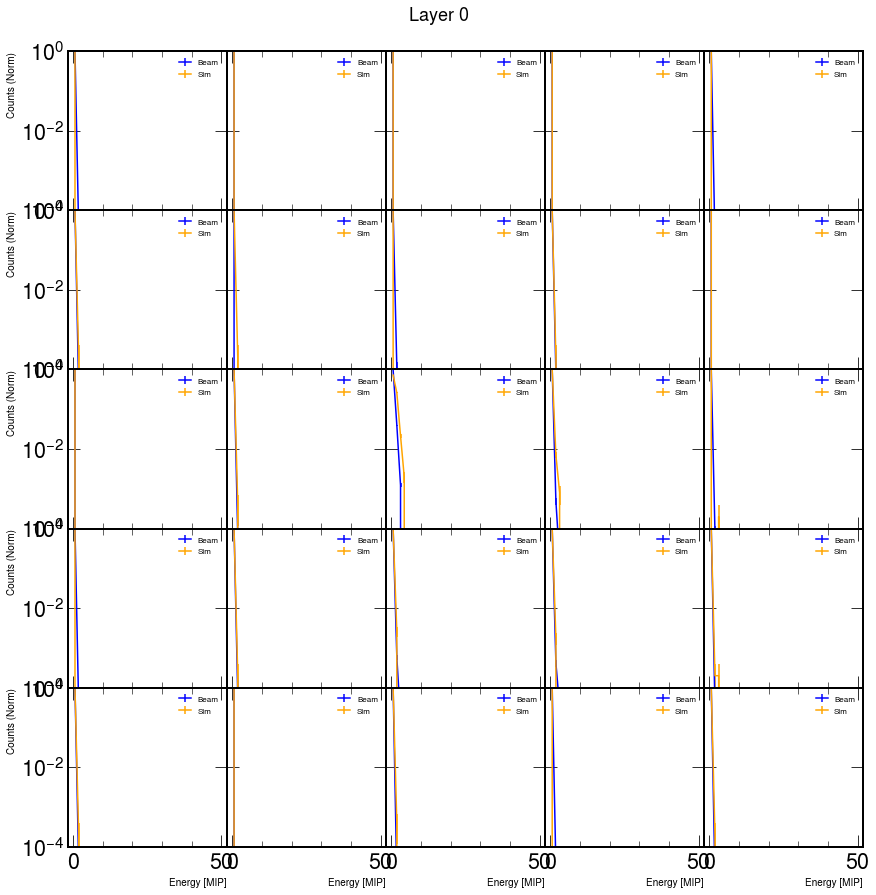

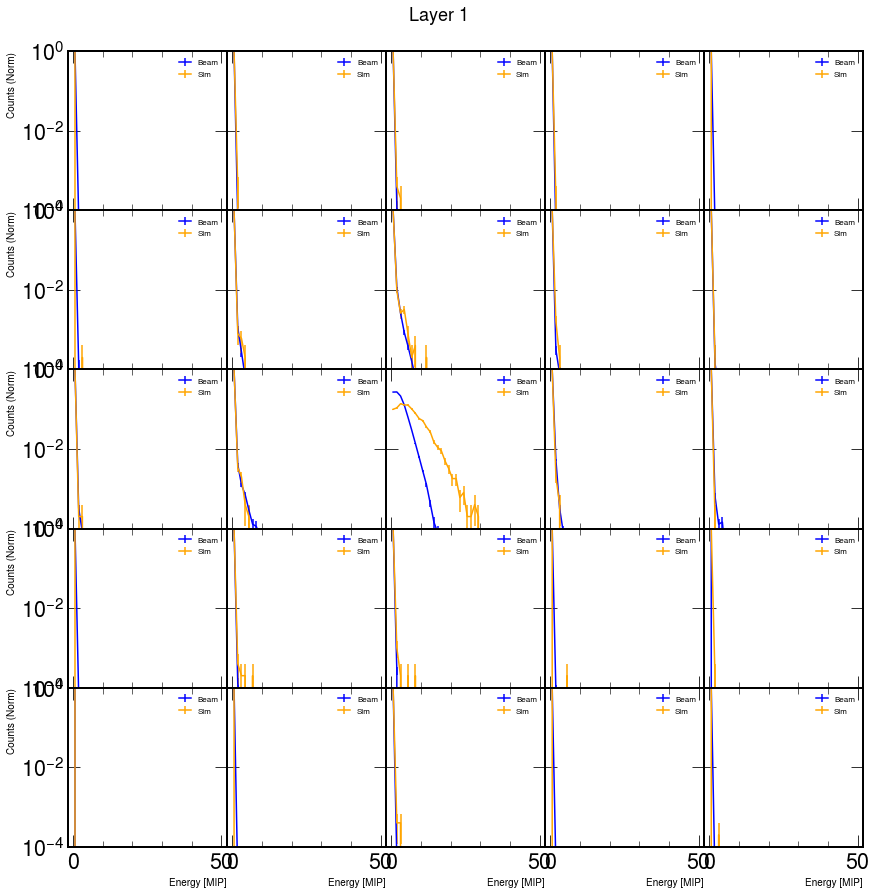

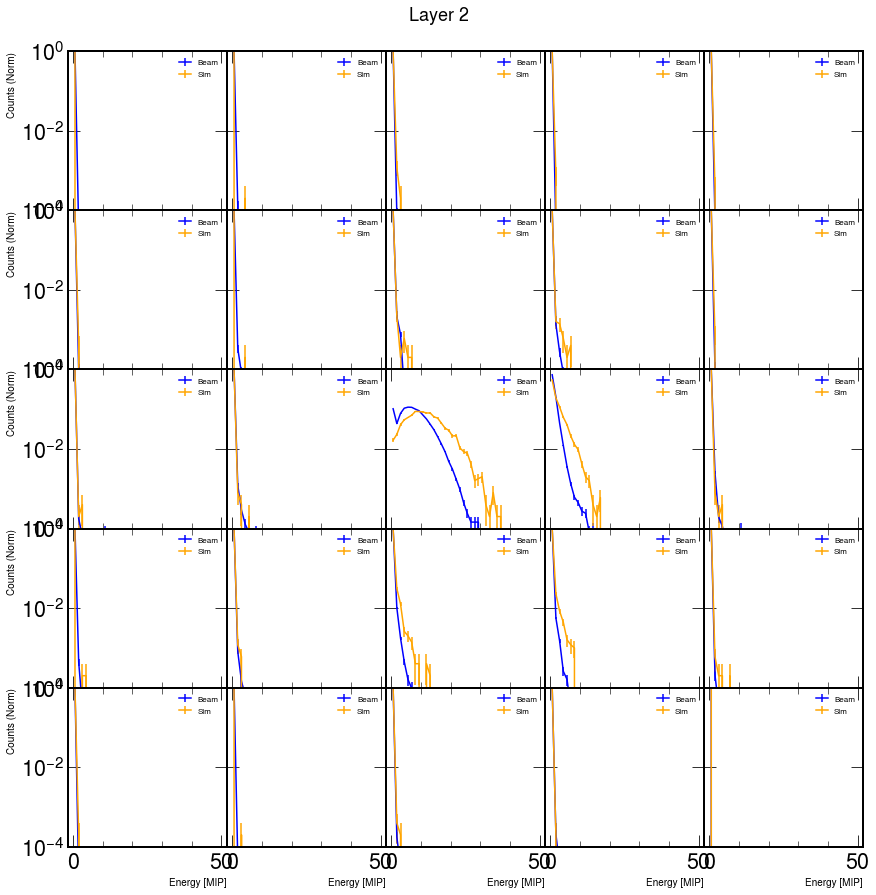

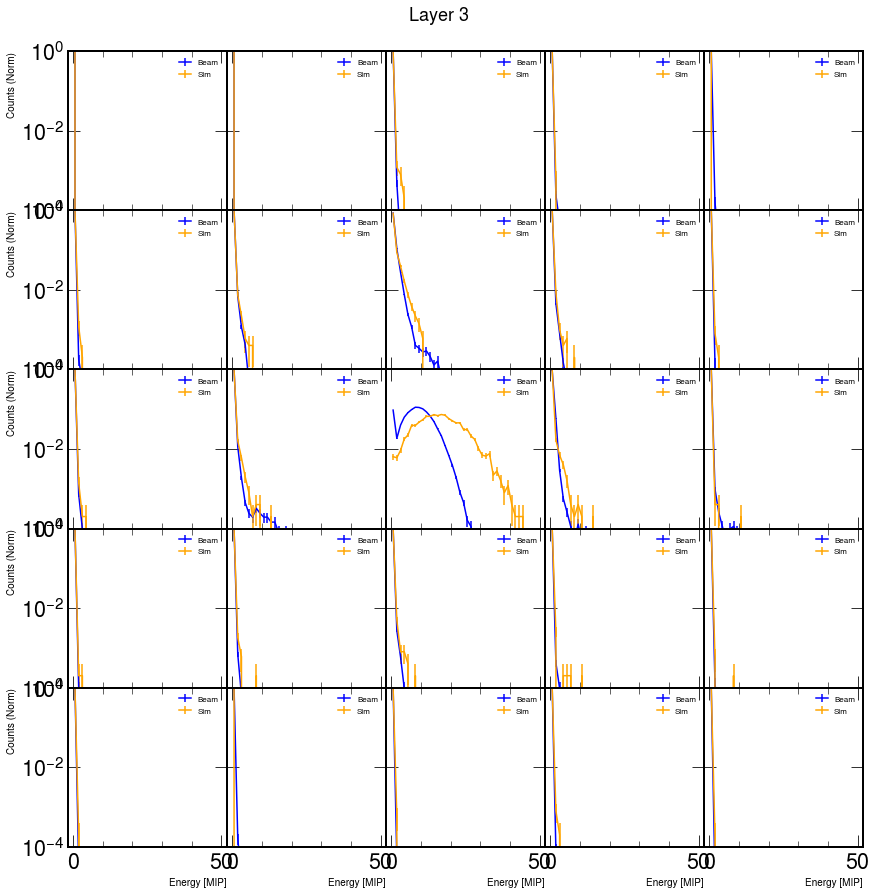

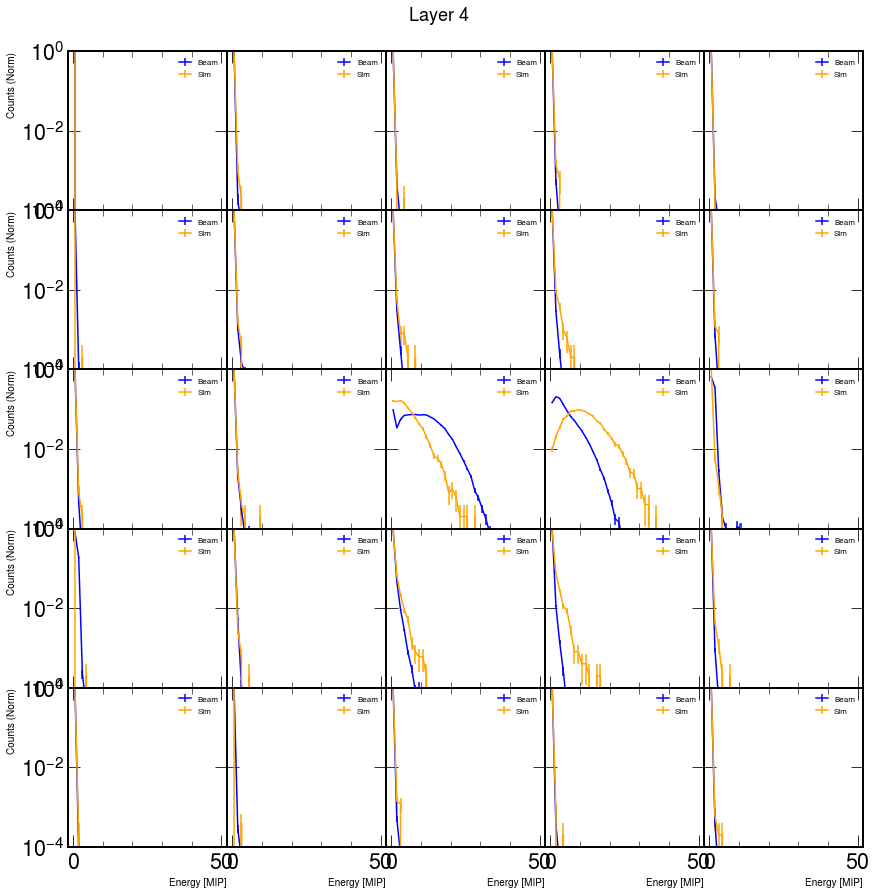

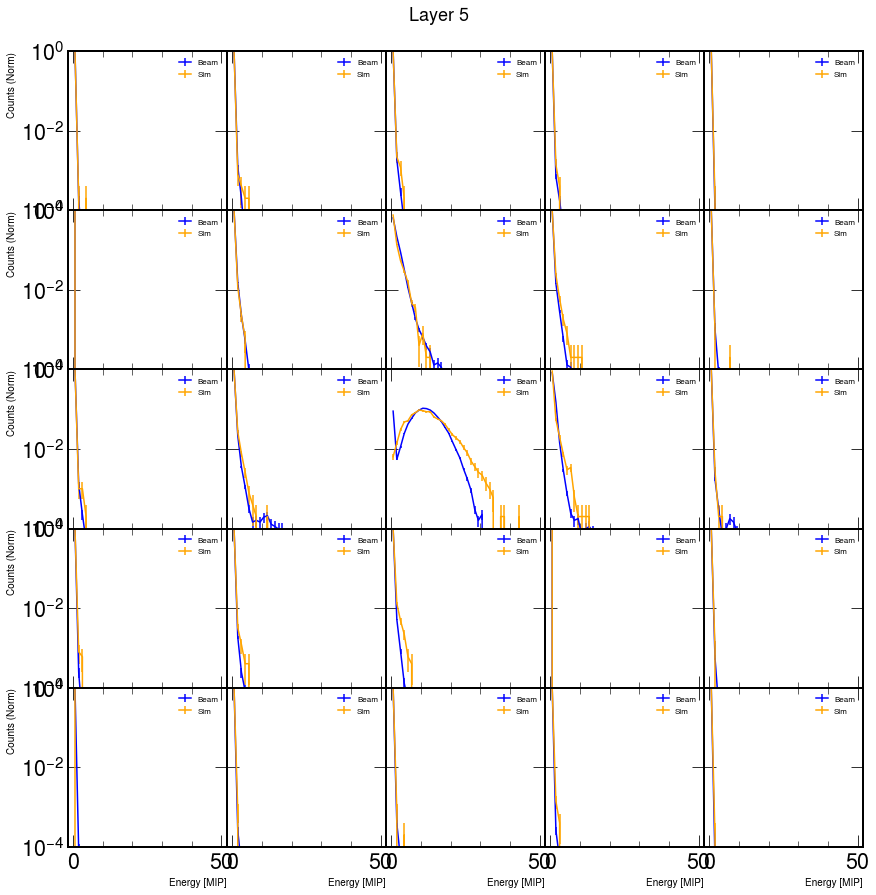

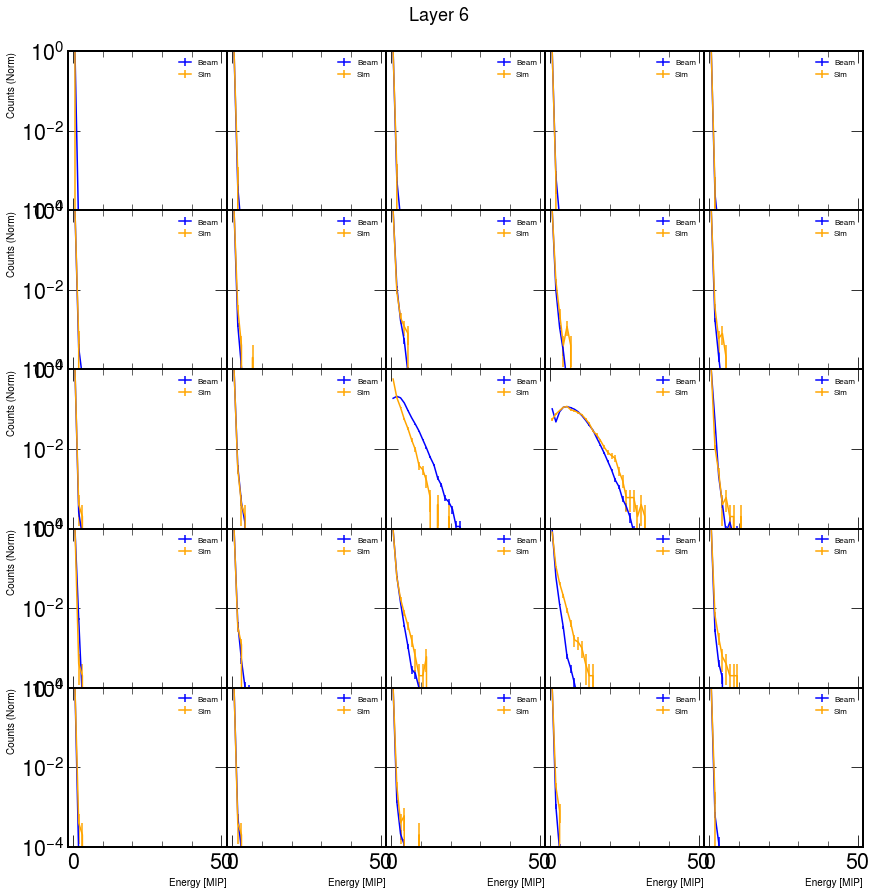

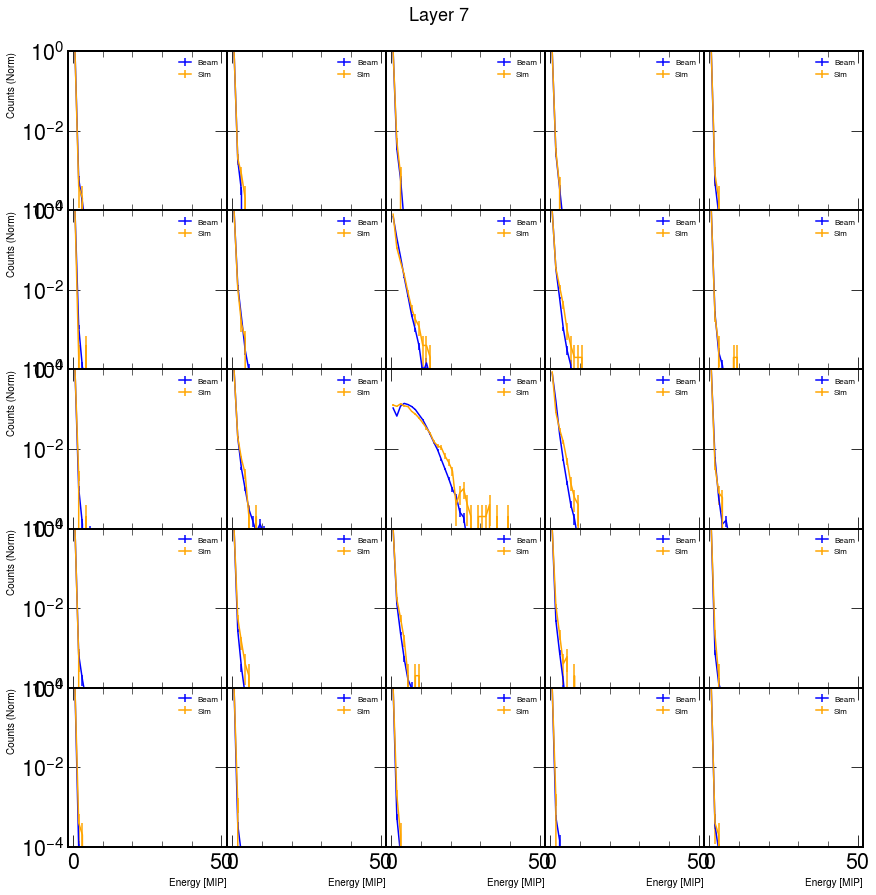

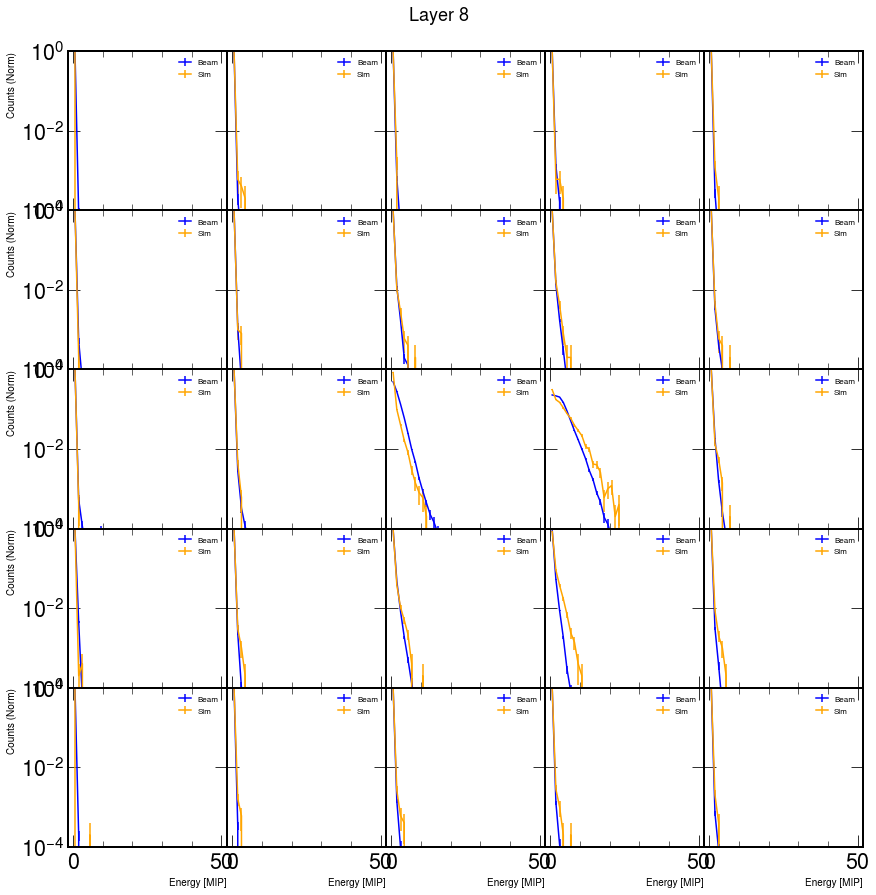

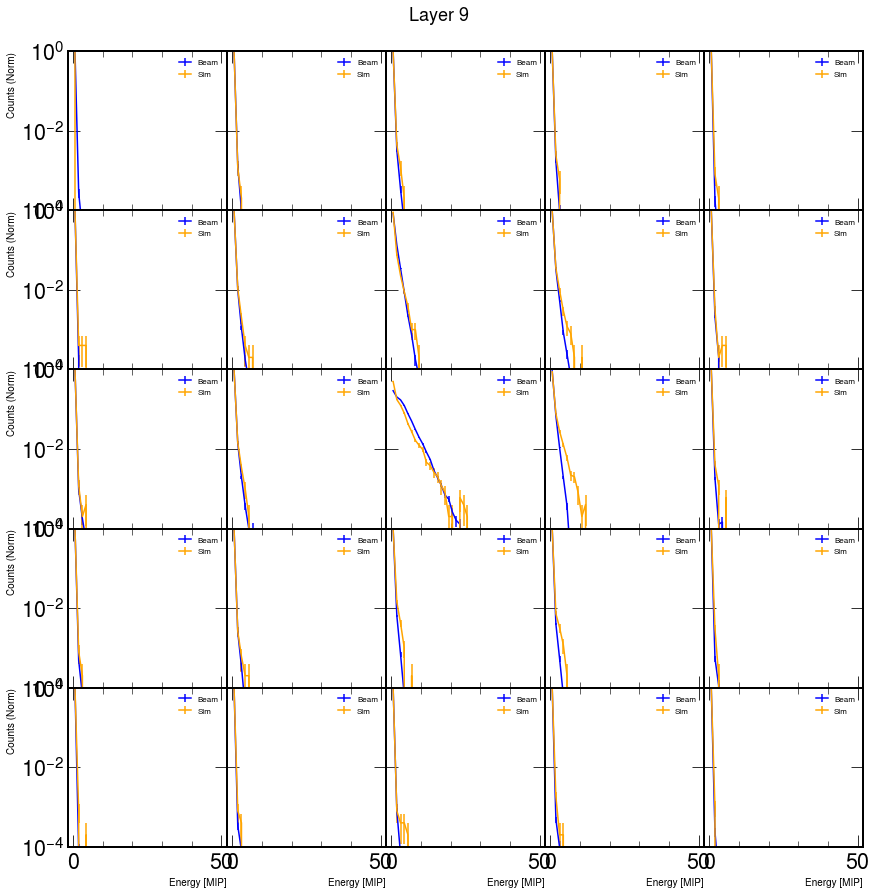

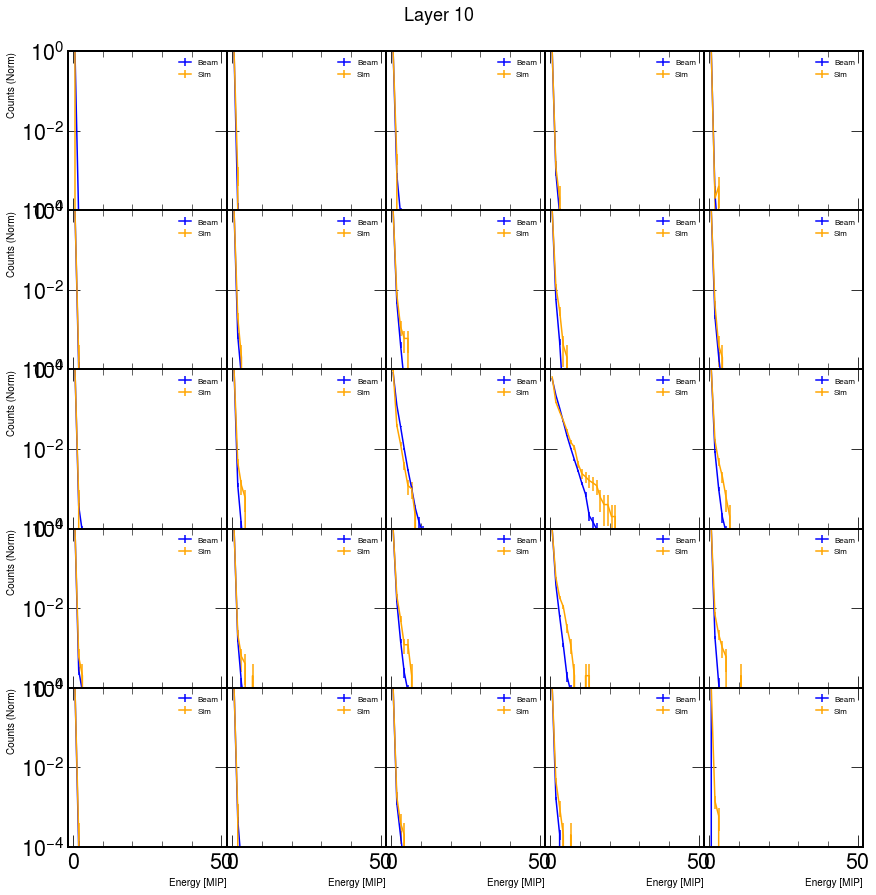

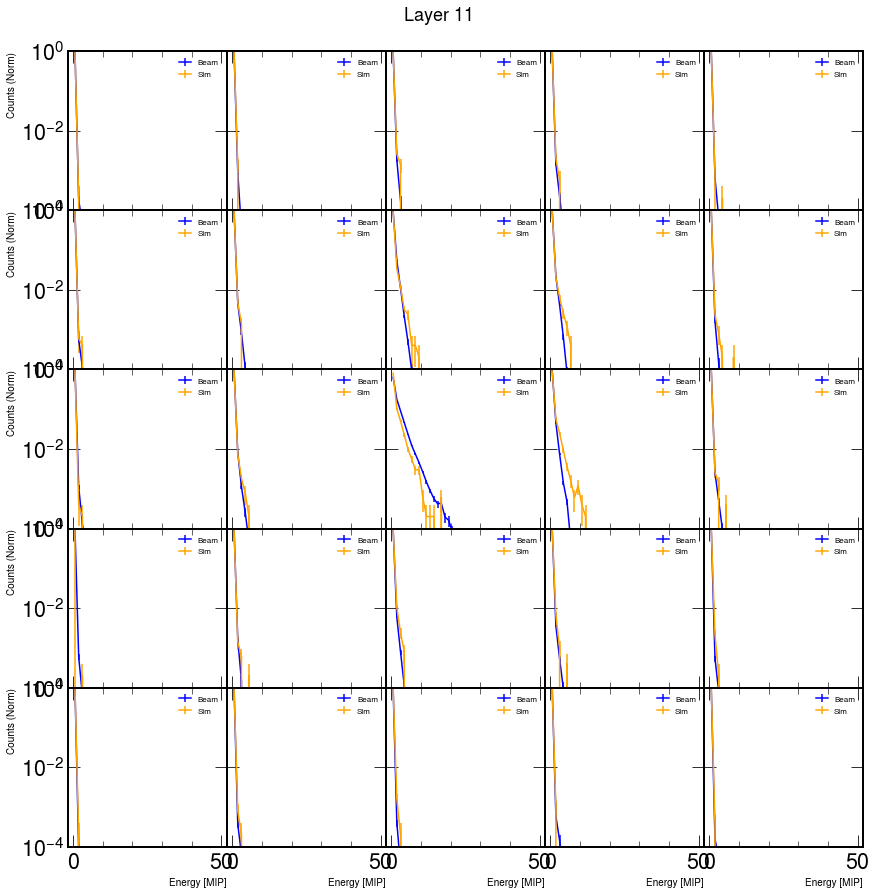

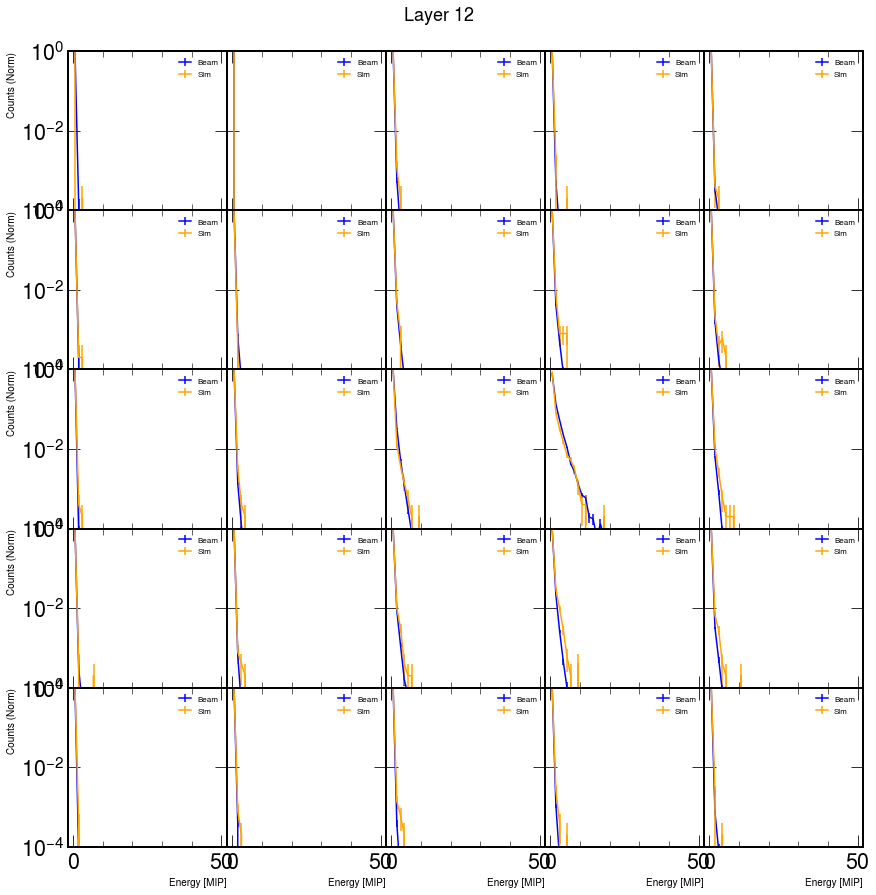

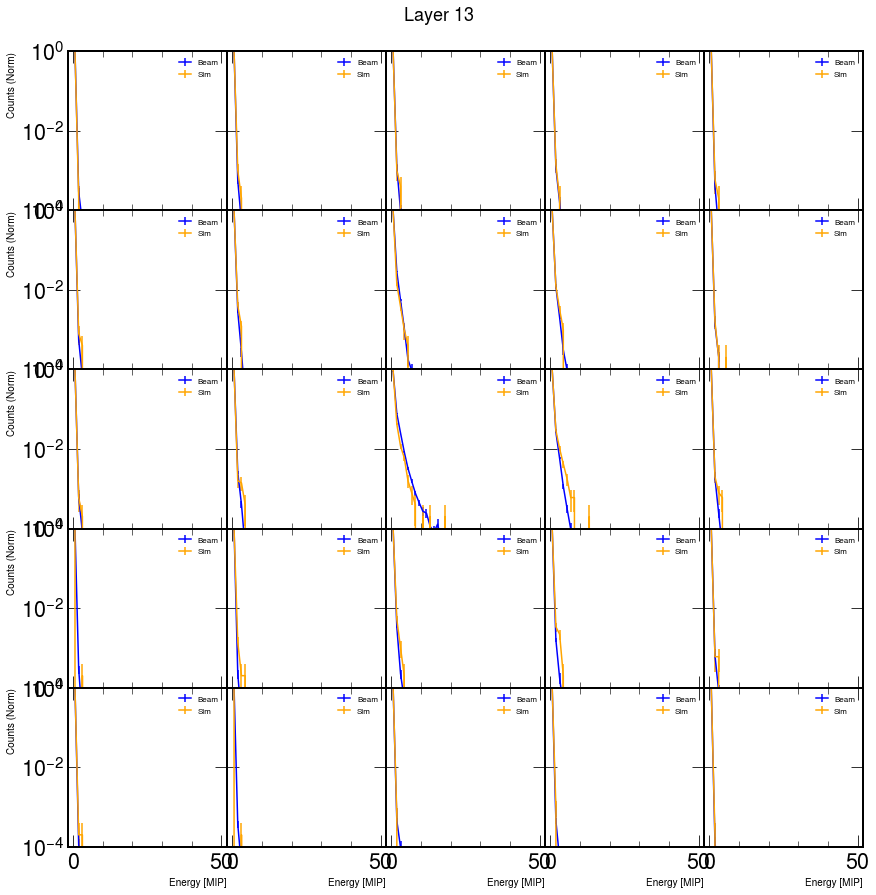

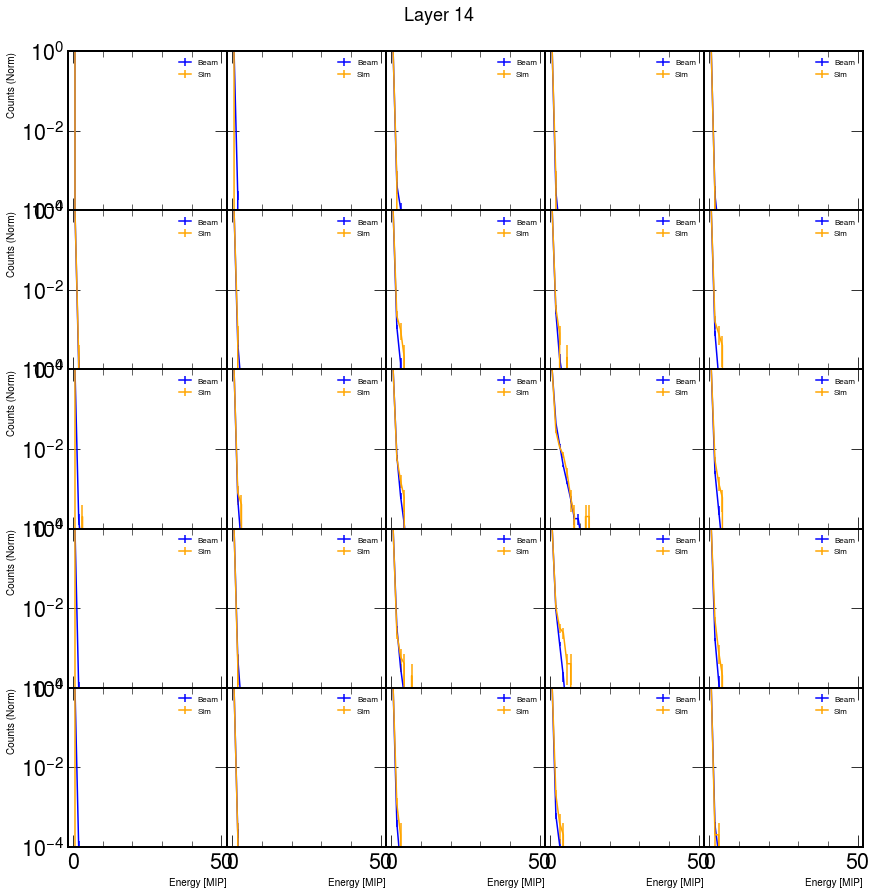

In [91]:
for i in range(15):
    plot_layer_histograms(beam_data, sim_data, i, bins=40)

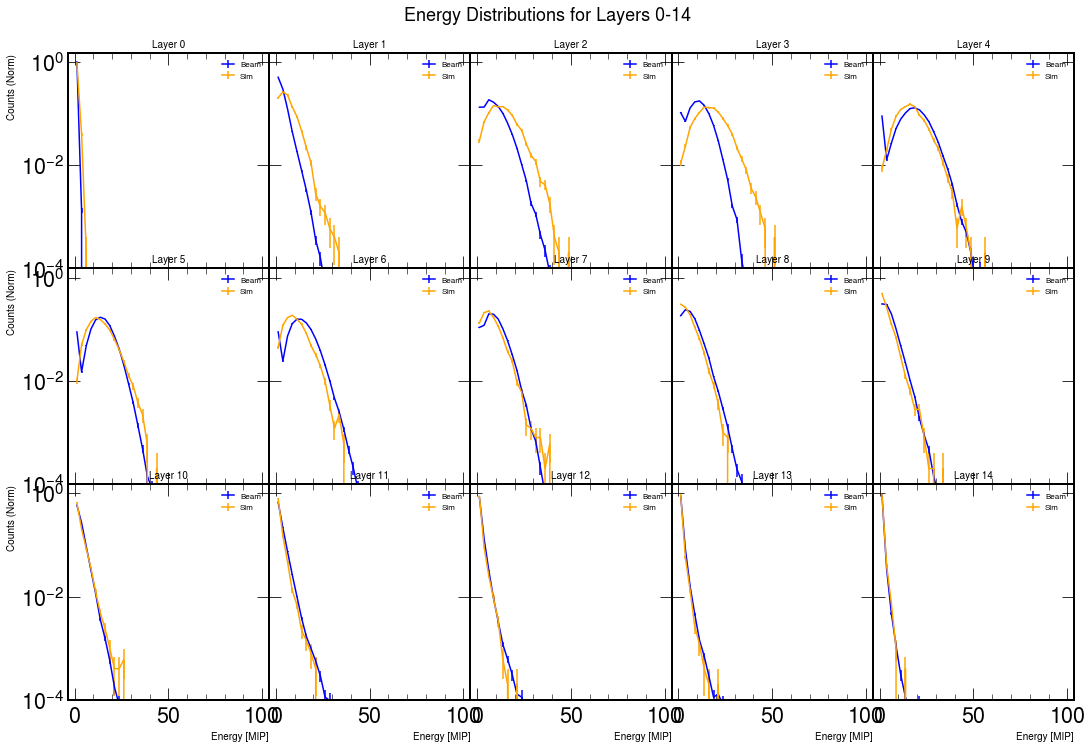

In [92]:
plot_all_layers(beam_data, sim_data)

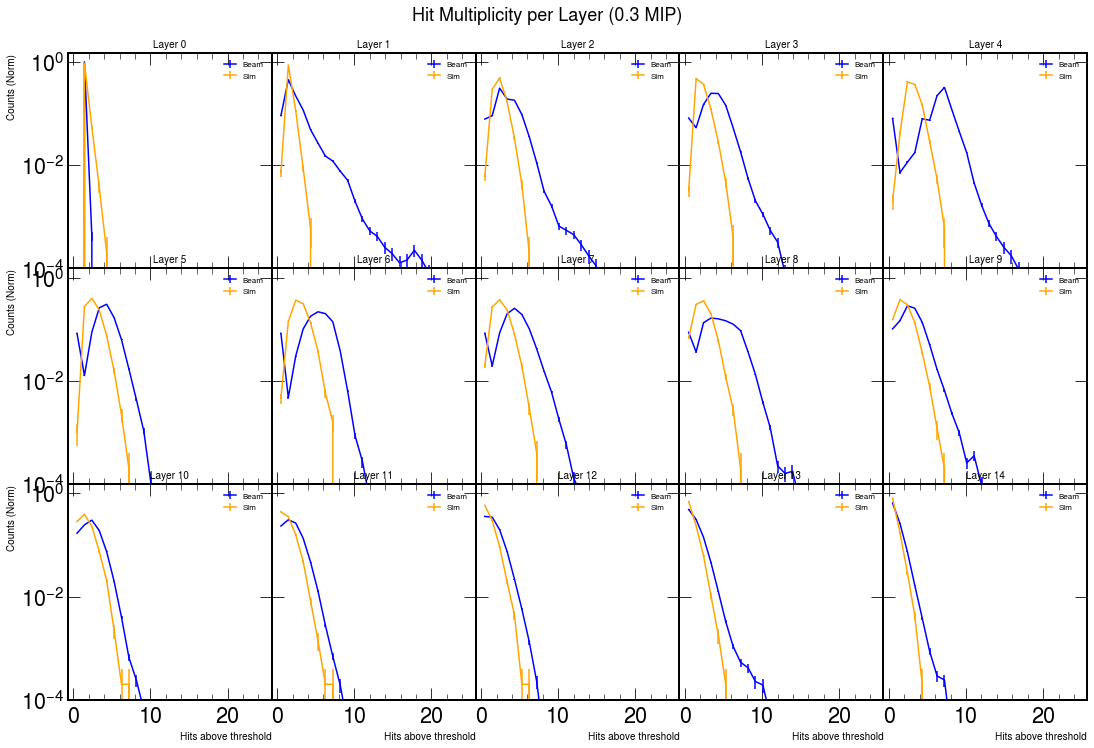

In [93]:
plot_mult_layers(beam_data, sim_data)

In [94]:
beam_energies = total_event_energies(beam_data)
sim_energies = total_event_energies(sim_data)
beam_mult = hit_multiplicities(beam_data)
sim_mult = hit_multiplicities(sim_data)

beam_high_indexes = []
for i in range(len(beam_energies)):
    if(beam_energies[i] > 50):
        beam_high_indexes.append(i)
        
sim_high_indexes = []
for i in range(len(sim_energies)):
    if(sim_energies[i] > 50):
        sim_high_indexes.append(i)

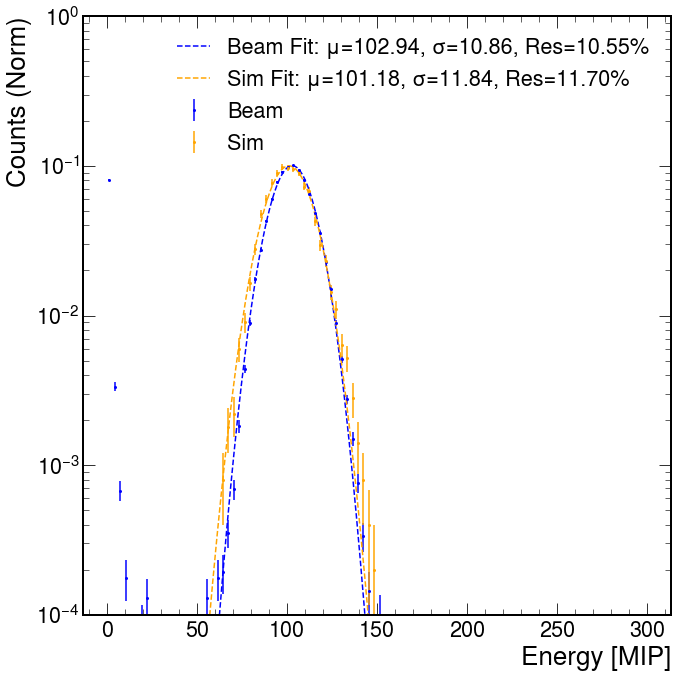

In [95]:
def fit_gaussian_histogram(energies, bin_centers, counts, errors, total_events, color, label_prefix):
    # Only use bins with data
    mask = counts > 0
    x = bin_centers[mask]
    y = counts[mask] / total_events
    yerr = errors[mask] / total_events

    # Initial guesses
    init = [max(y), np.mean(energies[energies > 50]), np.std(energies[energies > 50])]
    least_squares = LeastSquares(x, y, yerr, gauss)
    m = Minuit(least_squares, A=init[0], mu=init[1], sigma=init[2])
    m.limits["sigma"] = (0, None)
    m.migrad()

    # Fit values
    A, mu, sigma = m.values["A"], m.values["mu"], m.values["sigma"]
    fit_x = np.linspace(bin_centers[0], bin_centers[-1], 1500)
    fit_y = gauss(fit_x, A, mu, sigma)
    resolution = (sigma / mu) * 100

    plt.plot(fit_x, fit_y, color=color, linestyle='--',
             label=f"{label_prefix} Fit: μ={mu:.2f}, σ={sigma:.2f}, Res={resolution:.2f}%")
    
    return m  # Optionally return fit result for further use

def plot_energy_histogram(beam_energies, sim_energies, bins=100, x_range=(0, 100),
                          xlabel="Energy [MIP]", ylabel="Counts (Norm)"):
    configure_plotting()

    # Histogram beam
    num_beam = len(beam_energies)
    beam_counts, bin_edges = np.histogram(beam_energies, bins=bins, range=x_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    beam_errors = np.sqrt(beam_counts)

    # Histogram sim
    num_sim = len(sim_energies)
    sim_counts, _ = np.histogram(sim_energies, bins=bin_edges)
    sim_errors = np.sqrt(sim_counts)

    # Plot data
    plt.errorbar(bin_centers, beam_counts/num_beam, yerr=beam_errors/num_beam,
                 fmt='o', markersize=2, color='blue', label='Beam')
    plt.errorbar(bin_centers, sim_counts/num_sim, yerr=sim_errors/num_sim,
                 fmt='o', markersize=2, color='orange', label='Sim')

    # Fit and plot
    fit_gaussian_histogram(beam_energies, bin_centers, beam_counts, beam_errors, num_beam, 'blue', 'Beam')
    fit_gaussian_histogram(sim_energies, bin_centers, sim_counts, sim_errors, num_sim, 'orange', 'Sim')

    # Plot formatting
    plt.yscale('log')
    plt.ylim(0.0001, 1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_energy_histogram(beam_energies, sim_energies, bins=100, x_range=(0, 300))

In [96]:
def plot_energy_mult_histogram(energies, mult, title):
    configure_plotting()
    xlabel="Hit Multiplicity" 
    ylabel="Event Energy [MIP]"
    H, energies_edges, mult_edges = np.histogram2d(energies[energies>3], mult[energies>3],
                                           bins=[50, 80],
                                           range=[[0, 150], [0, 80]])

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(mult_edges, energies_edges, H, cmap='viridis')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()
    
def plot_mult_histogram(beam_mult, sim_mult, bins=30, x_range=(0, 100),
                          xlabel="Hit Multiplicity", ylabel="Counts (Norm)"):
    configure_plotting()

    # Histogram beam
    num_beam = len(beam_mult)
    beam_counts, bin_edges = np.histogram(beam_mult, bins=bins, range=x_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    beam_errors = np.sqrt(beam_counts)

    # Histogram sim
    num_sim = len(sim_mult)
    sim_counts, _ = np.histogram(sim_mult, bins=bin_edges)
    sim_errors = np.sqrt(sim_counts)

    # Plot data
    plt.errorbar(bin_centers, beam_counts/num_beam, yerr=beam_errors/num_beam,
                 fmt='-', markersize=2, color='blue', label='Beam')
    plt.errorbar(bin_centers, sim_counts/num_sim, yerr=sim_errors/num_sim,
                 fmt='-', markersize=2, color='orange', label='Sim')


    # Plot formatting
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

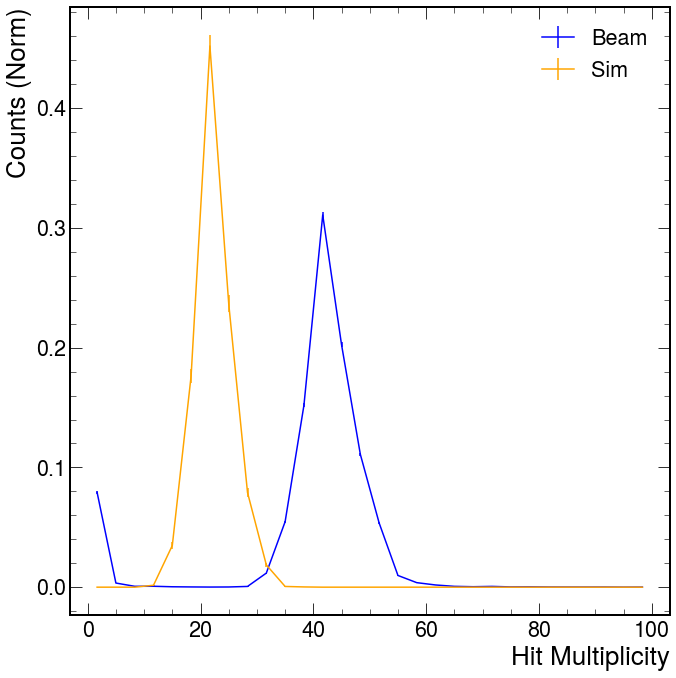

In [97]:
plot_mult_histogram(beam_mult, sim_mult)

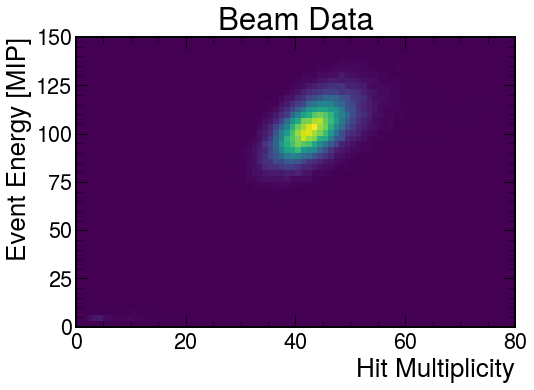

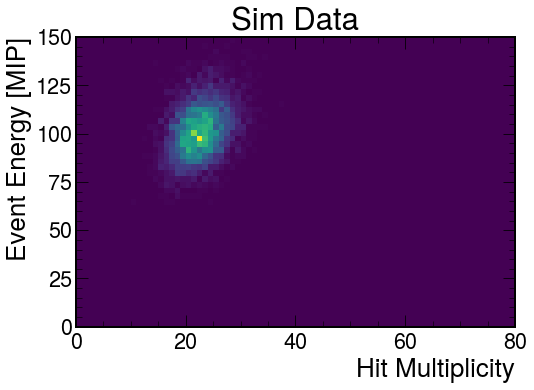

In [98]:
plot_energy_mult_histogram(beam_energies, beam_mult, "Beam Data")
plot_energy_mult_histogram(sim_energies, sim_mult, "Sim Data")

In [99]:
def layer_cog(data, target_layer):
    positions = np.array(data['positions'])  # shape: (num_channels, 5) -> x, y, z, layer, ch#
    events = data['events']  # shape: (num_events,), each item: (num_channels,)
    
    x = positions[:, 0]
    y = positions[:, 1]
    layer_mask = positions[:, 3] == target_layer

    cogs = []
    for event in events:
        energies = event[layer_mask]
        x_layer = x[layer_mask]
        y_layer = y[layer_mask]

        # Apply energy cut
        mask = energies > e_cut
        energies = energies[mask]
        x_selected = x_layer[mask]
        y_selected = y_layer[mask]

        if energies.sum() > 0:
            cog_x = np.average(x_selected, weights=energies)
            cog_y = np.average(y_selected, weights=energies)
        else:
            cog_x, cog_y = np.nan, np.nan  # or use 0.0, depending on your needs

        cogs.append((cog_x, cog_y))

    return np.array(cogs)

def compute_w0(energy_sum, reference_energy_mips=2122.18):
    if energy_sum <= 0:
        return 0.0  # Or np.nan if you prefer
    u = np.log(energy_sum / reference_energy_mips)
    return 5.8 + 0.65 * u + 0.31 * u**2

def compute_cog_vector(energies, positions):
    energies = np.asarray(energies, dtype=np.float32)
    positions = np.asarray(positions, dtype=np.float32)

    mask = energies > e_cut
    if np.count_nonzero(mask) == 0:
        return np.array([np.nan, np.nan, np.nan], dtype=np.float32)

    energies = energies[mask]
    pos = positions[mask]
    energy_sum = energies.sum()

    if energy_sum <= 0:
        return np.array([np.nan, np.nan, np.nan], dtype=np.float32)

    w0 = compute_w0(energy_sum)
    w0 = energy_sum

    with np.errstate(divide='ignore', invalid='ignore'):
        #weights = np.maximum(0, w0 + np.log(energies / energy_sum))
        weights = energies / energy_sum

    if np.sum(weights) == 0:
        return np.array([np.nan, np.nan, np.nan], dtype=np.float32)

    cog = np.average(pos, axis=0, weights=weights)
    return cog

def compute_event_moment_matrix(energies, positions):
    """
    Computes the 3x3 moment matrix of an event using energy-based weights.

    Parameters:
        energies: (N,) array of energy deposits (in MIPs)
        positions: (N, 3) array of x, y, z positions
        e_cut: float, energy threshold (in MIPs)

    Returns:
        moment_matrix: (3, 3) ndarray representing the moment matrix
    """
    energies = np.asarray(energies, dtype=np.float32)
    positions = np.asarray(positions, dtype=np.float32)

    mask = energies > e_cut
    if np.count_nonzero(mask) == 0:
        return np.full((3, 3), np.nan, dtype=np.float32)

    energies = energies[mask]
    positions = positions[mask]
    energy_sum = energies.sum()

    if energy_sum <= 0:
        return np.full((3, 3), np.nan, dtype=np.float32)

    # Compute weights
    with np.errstate(divide='ignore', invalid='ignore'):
        weights = energies / energy_sum
        
    if np.sum(weights) == 0:
        return np.full((3, 3), np.nan, dtype=np.float32)

    # Compute COG
    cog = np.average(positions, axis=0, weights=weights)

    # Compute deltas
    deltas = positions - cog

    # Moment matrix: sum of outer products, weighted
    weighted_outer_products = np.einsum('i,ij,ik->jk', weights, deltas, deltas)
    moment_matrix = weighted_outer_products / np.sum(weights)

    return moment_matrix

def compute_cluster_orientation(moment_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(moment_matrix)

    # Principal axis = eigenvector with largest eigenvalue
    principal_index = np.argmax(eigenvalues)
    principal_axis = eigenvectors[:, principal_index]  # shape (3,)

    # Normalize (optional but helpful for unit direction)
    principal_axis /= np.linalg.norm(principal_axis)
    x, y, z = principal_axis
    theta = np.arccos(z)           # angle from z-axis
    phi = np.arctan2(y, x)         # angle in x-y plane

    return eigenvalues, eigenvectors, principal_axis, theta, phi

def project_to_xy_plane(cog, theta, phi):

    cog = np.array(cog)
    
    # Convert spherical to Cartesian direction vector
    dir_vector = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    # Avoid division by zero if direction is parallel to xy-plane
    if dir_vector[2] == 0:
        raise ValueError("Direction is parallel to the xy-plane; no intersection with z=0.")
    
    # Calculate t such that z = 0 => cog[2] + t * dir_vector[2] = 0
    t = -cog[2] / dir_vector[2]
    
    # Compute intersection point
    intersection = cog + t * dir_vector
    return intersection[0], intersection[1]

In [124]:
def plot_layer_cog_distributions(sim_data, beam_data, max_layer, coord='x', bins=50):
    configure_plotting()
    coord_idx = 0 if coord == 'x' else 1

    fig, axes = plt.subplots(nrows=max_layer // 4 + 1, ncols=4, figsize=(16, 3 * (max_layer // 4 + 1)))
    axes = axes.flatten()

    for layer in range(max_layer):
        sim_cogs = layer_cog(sim_data, layer)[sim_high_indexes]
        real_cogs = layer_cog(beam_data, layer)[beam_high_indexes]

        sim_vals = sim_cogs[:, coord_idx]
        real_vals = real_cogs[:, coord_idx]

        # Remove NaNs
        sim_vals = sim_vals[~np.isnan(sim_vals)]
        real_vals = real_vals[~np.isnan(real_vals)]

        num_sim = len(sim_vals)
        num_real = len(real_vals)

        if num_sim == 0 or num_real == 0:
            axes[layer].set_title(f'Layer {layer} (no data)')
            axes[layer].axis('off')
            continue
        
        # Histogram
        real_counts, bin_edges = np.histogram(real_vals, bins=bins, range=[-100,100])
        sim_counts, _ = np.histogram(sim_vals, bins=bin_edges)

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        real_errors = np.sqrt(real_counts)
        sim_errors = np.sqrt(sim_counts)

        ax = axes[layer]
        ax.errorbar(bin_centers, real_counts / num_real, yerr=real_errors / num_real,
                    fmt='-', markersize=2, color='blue', label=f'Layer {layer} Beam')
        ax.errorbar(bin_centers, sim_counts / num_sim, yerr=sim_errors / num_sim,
                    fmt='-', markersize=2, color='orange', label=f'Layer {layer} Sim')
        ax.legend(fontsize=10)
        ax.set_xlabel("X Position", fontsize=10)
        ax.set_ylabel("Count (Norm)", fontsize=10)

    # Hide any unused subplots
    for i in range(max_layer, len(axes)):
        axes[i].axis('off')
    plt.suptitle("Layer Y COG", fontsize=18, y=1)
    plt.tight_layout()
    plt.show()


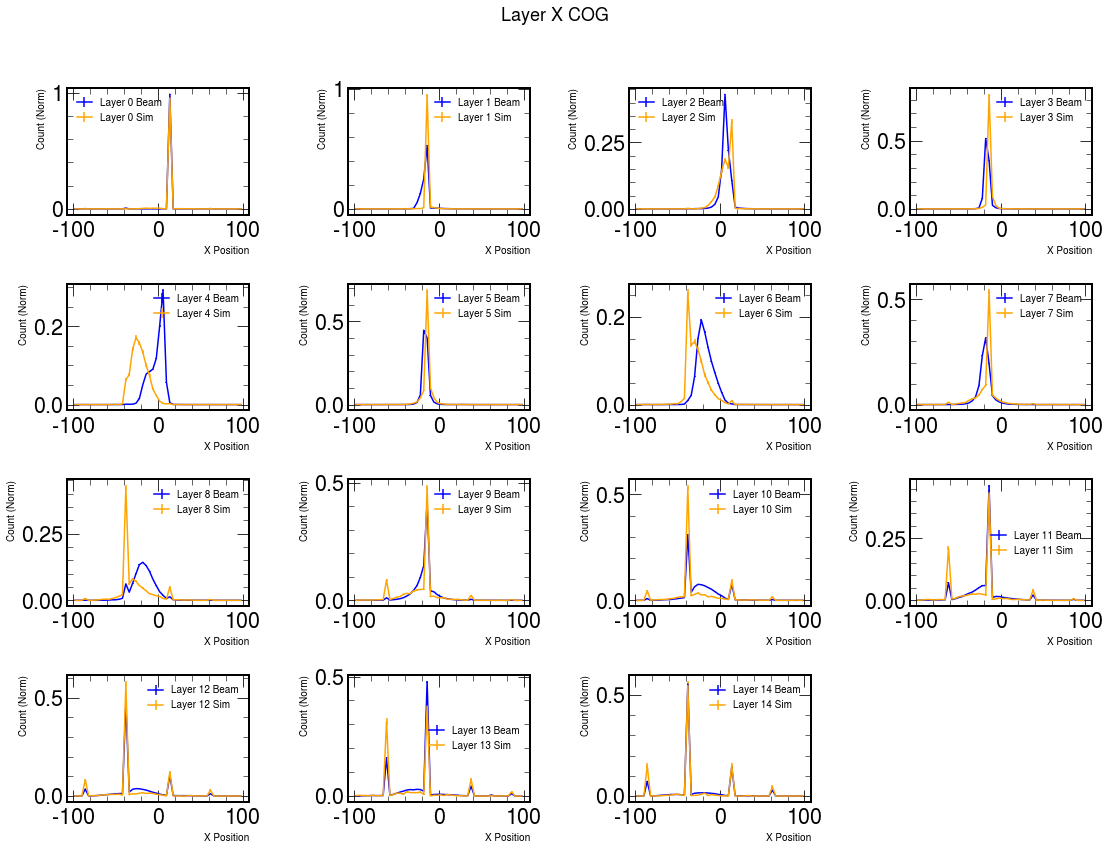

In [122]:
plot_layer_cog_distributions(sim_data, beam_data, 15, 'x')

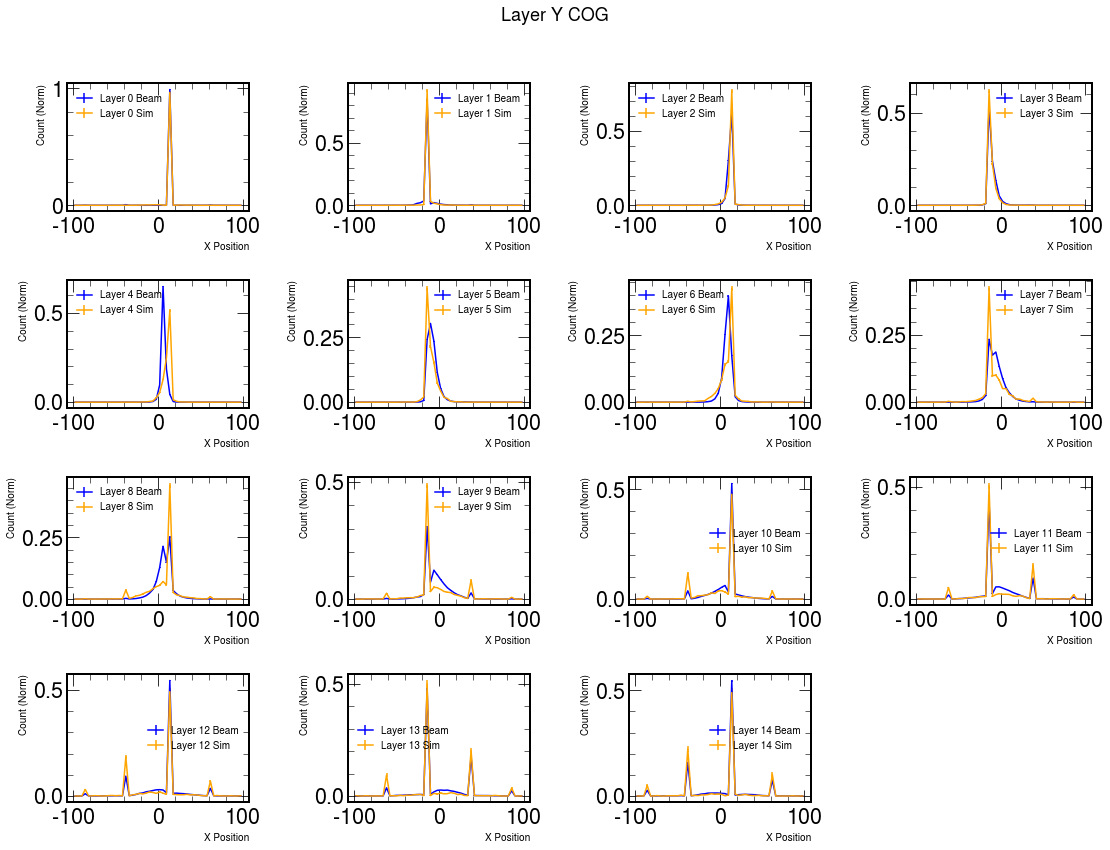

In [125]:
plot_layer_cog_distributions(sim_data, beam_data, 15, 'y')

In [103]:
beam_thetas = []
beam_phis = []
beam_cog = []
beam_x = []
beam_y = []
        
totE = total_event_energies(beam_data)
positions = beam_data["positions"][:, :3] 

for i in beam_high_indexes:
    try:
        moment_matrix = compute_event_moment_matrix(beam_data['events'][i], positions)
        _, _, _, theta, phi = compute_cluster_orientation(moment_matrix)
        cog = compute_cog_vector(beam_data["events"][i], positions)
        beam_cog.append(cog)
        beam_thetas.append(theta)
        beam_phis.append(phi)
        x, y = project_to_xy_plane(cog, theta, phi)
        beam_x.append(y)
        beam_y.append(x)
    except:
        print("skip")

beam_x = np.array(beam_x)
beam_y = np.array(beam_y)
beam_thetas = np.array(beam_thetas)
beam_phis = np.array(beam_phis)
beam_cog = np.array(beam_cog)

sim_thetas = []
sim_phis = []
sim_cog = []
sim_x = []
sim_y = []
        
positions = sim_data["positions"][:, :3] 

for i in sim_high_indexes:
    try:
        moment_matrix = compute_event_moment_matrix(sim_data['events'][i], positions)
        _, _, _, theta, phi = compute_cluster_orientation(moment_matrix)
        cog = compute_cog_vector(sim_data["events"][i], positions)
        sim_cog.append(cog)
        sim_thetas.append(theta)
        sim_phis.append(phi)
        x, y = project_to_xy_plane(cog, theta, phi)
        sim_x.append(y)
        sim_y.append(x)
    except:
        print("skip")

sim_x = np.array(sim_x)
sim_y = np.array(sim_y)
sim_thetas = np.array(sim_thetas)
sim_phis = np.array(sim_phis)
sim_cog = np.array(sim_cog)

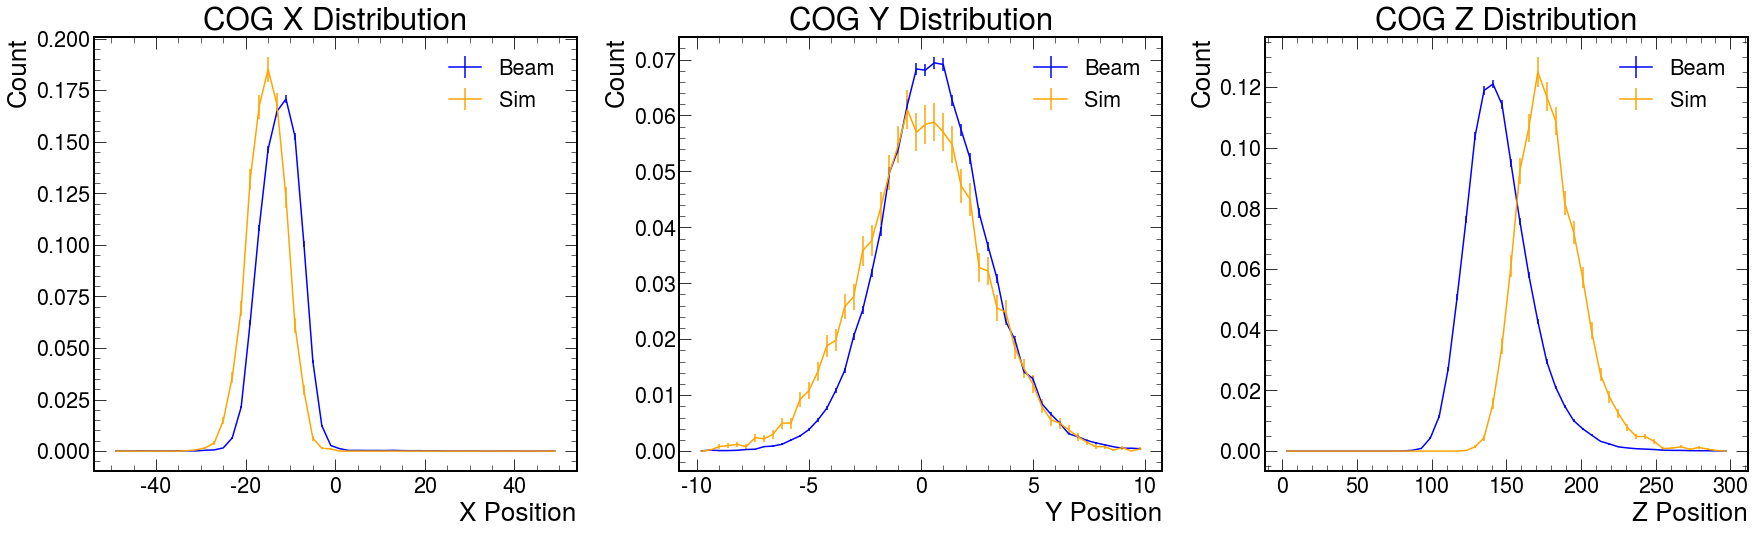

In [104]:
# Settings
bins = 50
range_dict = {
    'X': [-50, 50],
    'Y': [-10, 10],
    'Z': [0, 300]
}
labels = ['X', 'Y', 'Z']

fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=False)

for i, ax in enumerate(axes):
    # Histogram for beam
    beam_counts, beam_edges = np.histogram(beam_cog[:, i], bins=bins, range=range_dict[labels[i]])
    beam_centers = (beam_edges[:-1] + beam_edges[1:]) / 2
    beam_errors = np.sqrt(beam_counts)

    # Histogram for sim
    sim_counts, sim_edges = np.histogram(sim_cog[:, i], bins=bins, range=range_dict[labels[i]])
    sim_centers = (sim_edges[:-1] + sim_edges[1:]) / 2
    sim_errors = np.sqrt(sim_counts)

    # Normalize by number of events
    num_beam_events = len(beam_cog)
    num_sim_events = len(sim_cog)

    ax.errorbar(beam_centers, beam_counts / num_beam_events,
                yerr=beam_errors / num_beam_events, fmt='-', markersize=2,
                color='blue', label='Beam')
    ax.errorbar(sim_centers, sim_counts / num_sim_events,
                yerr=sim_errors / num_sim_events, fmt='-', markersize=2,
                color='orange', label='Sim')

    ax.set_xlabel(f'{labels[i]} Position')
    ax.set_ylabel('Count')
    ax.set_title(f'COG {labels[i]} Distribution')
    ax.legend()

plt.tight_layout()
plt.show()

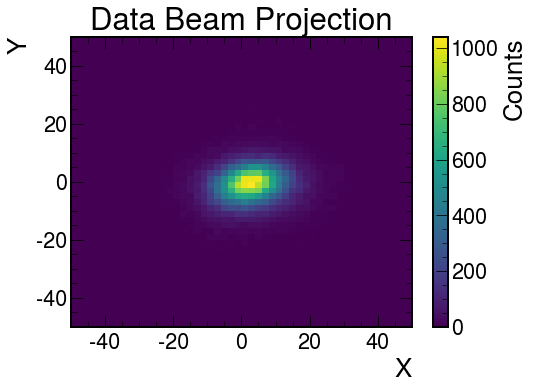

In [105]:
H, x_edges, y_edges = np.histogram2d(beam_x, beam_y,
                                           bins=[50, 50],
                                           range=[[-50, 50], [-50, 50]])

plt.figure(figsize=(8, 6))
plt.pcolormesh(x_edges, y_edges, H, shading='auto', cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data Beam Projection')
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()

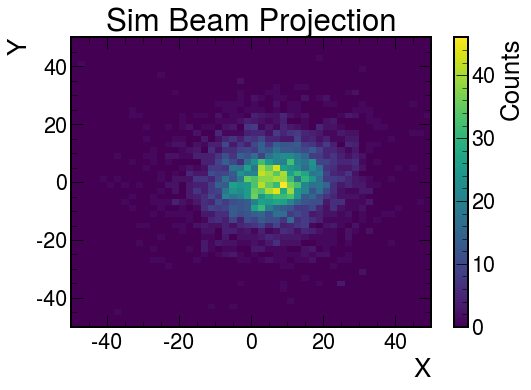

In [106]:
H, x_edges, y_edges = np.histogram2d(sim_x, sim_y,
                                           bins=[50, 50],
                                           range=[[-50, 50], [-50, 50]])

plt.figure(figsize=(8, 6))
plt.pcolormesh(x_edges, y_edges, H, shading='auto', cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sim Beam Projection')
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()

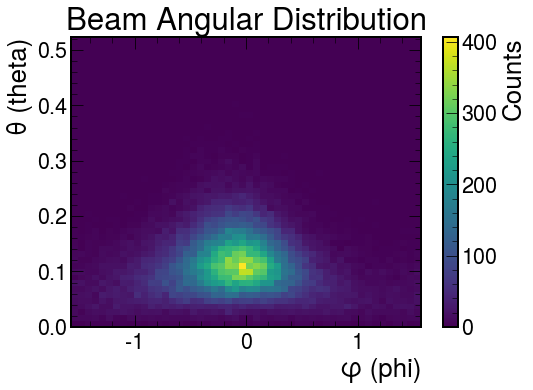

In [107]:
theta_folded = np.mod(beam_thetas, np.pi)
theta_folded = np.where(theta_folded > np.pi/2, np.pi - theta_folded, theta_folded)

phi_wrapped = (beam_phis + np.pi) % (2 * np.pi) - np.pi

phi_folded = np.where(phi_wrapped > np.pi/2, phi_wrapped - np.pi,
               np.where(phi_wrapped < -np.pi/2, phi_wrapped + np.pi, phi_wrapped))

theta_bins = 50
phi_bins = 50

H, theta_edges, phi_edges = np.histogram2d(theta_folded, phi_folded,
                                           bins=[theta_bins, phi_bins],
                                           range=[[0, np.pi/6], [-np.pi/2, np.pi/2]])

plt.figure(figsize=(8, 6))
plt.pcolormesh(phi_edges, theta_edges, H, shading='auto', cmap='viridis')
plt.xlabel('φ (phi)')
plt.ylabel('θ (theta)')
plt.title('Beam Angular Distribution')
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()

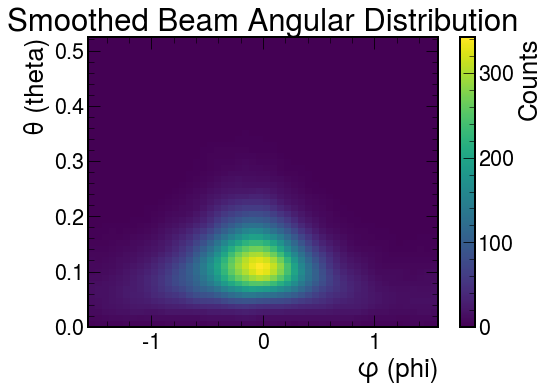

Maximum at θ ≈ 0.1100 rad, φ ≈ -0.0314 rad


In [108]:
from scipy.ndimage import gaussian_filter

# Your existing code (assuming thetas and phis are already defined and imported)
theta_folded = np.mod(beam_thetas, np.pi)
theta_folded = np.where(theta_folded > np.pi/2, np.pi - theta_folded, theta_folded)

phi_wrapped = (beam_phis + np.pi) % (2 * np.pi) - np.pi
phi_folded = np.where(phi_wrapped > np.pi/2, phi_wrapped - np.pi,
                      np.where(phi_wrapped < -np.pi/2, phi_wrapped + np.pi, phi_wrapped))

theta_bins = 50
phi_bins = 50

H, theta_edges, phi_edges = np.histogram2d(theta_folded, phi_folded,
                                           bins=[theta_bins, phi_bins],
                                           range=[[0, np.pi/6], [-np.pi/2, np.pi/2]])

# Smooth the histogram
H_smooth = gaussian_filter(H, sigma=1.0)  # Adjust sigma as needed

# Plot the smoothed histogram
plt.figure(figsize=(8, 6))
plt.pcolormesh(phi_edges, theta_edges, H_smooth, shading='auto', cmap='viridis')
plt.xlabel('φ (phi)')
plt.ylabel('θ (theta)')
plt.title('Smoothed Beam Angular Distribution')
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()

# Find the index of the maximum value
max_idx = np.unravel_index(np.argmax(H_smooth), H_smooth.shape)

# Get the center of the bin for theta and phi
theta_max = 0.5 * (theta_edges[max_idx[0]] + theta_edges[max_idx[0]+1])
phi_max = 0.5 * (phi_edges[max_idx[1]] + phi_edges[max_idx[1]+1])

print(f"Maximum at θ ≈ {theta_max:.4f} rad, φ ≈ {phi_max:.4f} rad")

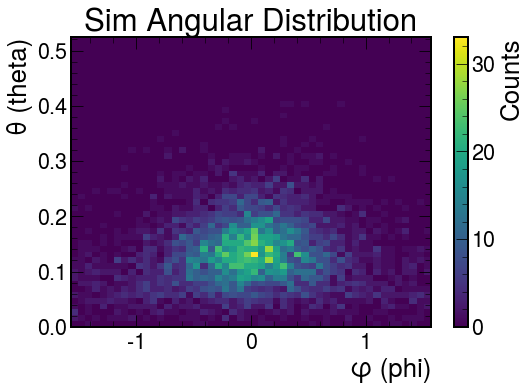

In [109]:
theta_folded = np.mod(sim_thetas, np.pi)
theta_folded = np.where(theta_folded > np.pi/2, np.pi - theta_folded, theta_folded)

phi_wrapped = (sim_phis + np.pi) % (2 * np.pi) - np.pi

phi_folded = np.where(phi_wrapped > np.pi/2, phi_wrapped - np.pi,
               np.where(phi_wrapped < -np.pi/2, phi_wrapped + np.pi, phi_wrapped))


theta_bins = 50
phi_bins = 50

H, theta_edges, phi_edges = np.histogram2d(theta_folded, phi_folded,
                                           bins=[theta_bins, phi_bins],
                                           range=[[0, np.pi/6], [-np.pi/2, np.pi/2]])

plt.figure(figsize=(8, 6))
plt.pcolormesh(phi_edges, theta_edges, H, shading='auto', cmap='viridis')
plt.xlabel('φ (phi)')
plt.ylabel('θ (theta)')
plt.title('Sim Angular Distribution')
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()

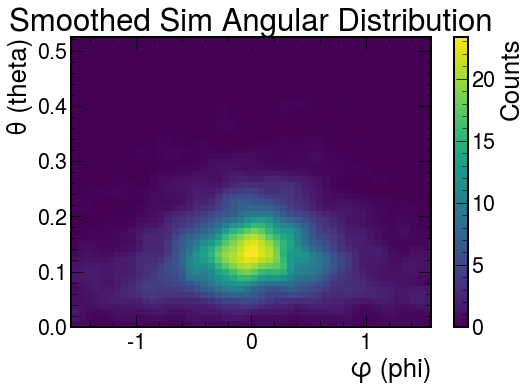

Maximum at θ ≈ 0.1309 rad, φ ≈ -0.0314 rad


In [110]:
sim_theta_folded = np.mod(sim_thetas, np.pi)
sim_theta_folded = np.where(sim_theta_folded > np.pi/2, np.pi - sim_theta_folded, sim_theta_folded)

sim_phi_wrapped = (sim_phis + np.pi) % (2 * np.pi) - np.pi
sim_phi_folded = np.where(sim_phi_wrapped > np.pi/2, sim_phi_wrapped - np.pi,
                      np.where(sim_phi_wrapped < -np.pi/2, sim_phi_wrapped + np.pi, sim_phi_wrapped))

theta_bins = 50
phi_bins = 50

H, theta_edges, phi_edges = np.histogram2d(sim_theta_folded, sim_phi_folded,
                                           bins=[theta_bins, phi_bins],
                                           range=[[0, np.pi/6], [-np.pi/2, np.pi/2]])

# Smooth the histogram
H_smooth = gaussian_filter(H, sigma=1.0)  # Adjust sigma as needed

# Plot the smoothed histogram
plt.figure(figsize=(8, 6))
plt.pcolormesh(phi_edges, theta_edges, H_smooth, shading='auto', cmap='viridis')
plt.xlabel('φ (phi)')
plt.ylabel('θ (theta)')
plt.title('Smoothed Sim Angular Distribution')
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()

# Find the index of the maximum value
max_idx = np.unravel_index(np.argmax(H_smooth), H_smooth.shape)

# Get the center of the bin for theta and phi
theta_max = 0.5 * (theta_edges[max_idx[0]] + theta_edges[max_idx[0]+1])
phi_max = 0.5 * (phi_edges[max_idx[1]] + phi_edges[max_idx[1]+1])

print(f"Maximum at θ ≈ {theta_max:.4f} rad, φ ≈ {phi_max:.4f} rad")

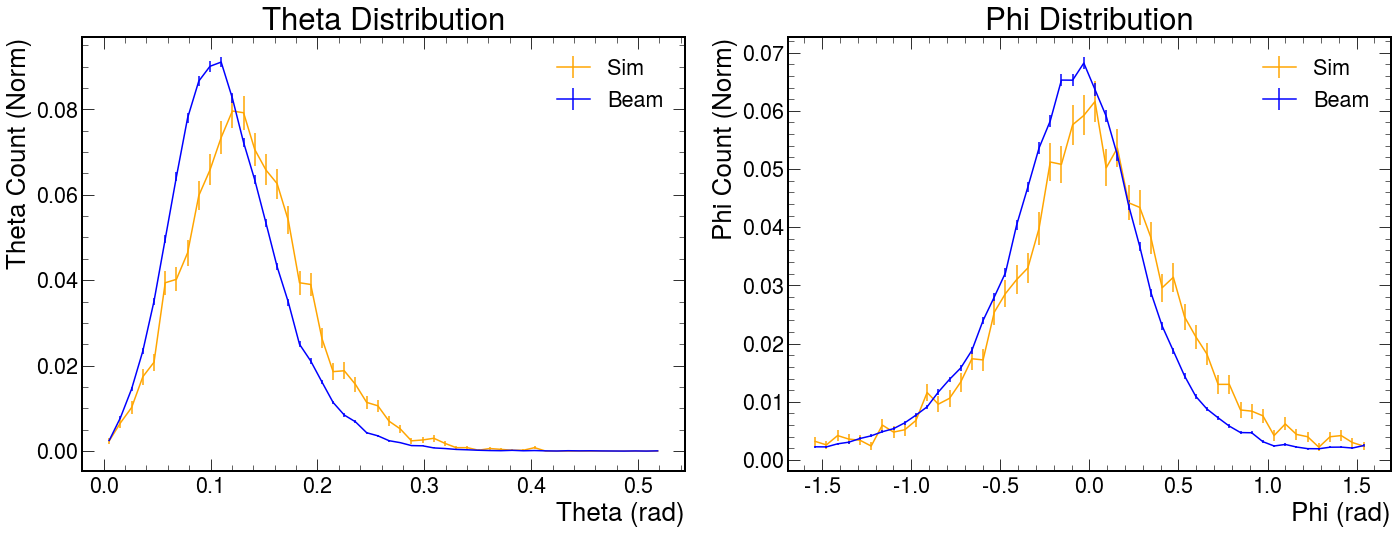

In [111]:
# Fold theta
sim_theta_folded = np.mod(sim_thetas, np.pi)
sim_theta_folded = np.where(sim_theta_folded > np.pi / 2, np.pi - sim_theta_folded, sim_theta_folded)

beam_theta_folded = np.mod(beam_thetas, np.pi)
beam_theta_folded = np.where(beam_theta_folded > np.pi / 2, np.pi - beam_theta_folded, beam_theta_folded)

# Fold phi
sim_phi_wrapped = (sim_phis + np.pi) % (2 * np.pi) - np.pi
sim_phi_folded = np.where(sim_phi_wrapped > np.pi / 2, sim_phi_wrapped - np.pi,
                          np.where(sim_phi_wrapped < -np.pi / 2, sim_phi_wrapped + np.pi, sim_phi_wrapped))

beam_phi_wrapped = (beam_phis + np.pi) % (2 * np.pi) - np.pi
beam_phi_folded = np.where(beam_phi_wrapped > np.pi / 2, beam_phi_wrapped - np.pi,
                           np.where(beam_phi_wrapped < -np.pi / 2, beam_phi_wrapped + np.pi, beam_phi_wrapped))

# Plot settings
theta_bins = 50
phi_bins = 50

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=False)

# --- Theta subplot ---
theta_counts_sim, theta_edges = np.histogram(sim_theta_folded, bins=theta_bins, range=[0, np.pi / 6])
theta_counts_beam, _ = np.histogram(beam_theta_folded, bins=theta_bins, range=[0, np.pi / 6])
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2

theta_errors_sim = np.sqrt(theta_counts_sim)
theta_errors_beam = np.sqrt(theta_counts_beam)

axes[0].errorbar(theta_centers, theta_counts_sim / num_sim_events,
                 yerr=theta_errors_sim / num_sim_events, fmt='-', markersize=2,
                 color='orange', label='Sim')
axes[0].errorbar(theta_centers, theta_counts_beam / num_beam_events,
                 yerr=theta_errors_beam / num_beam_events, fmt='-', markersize=2,
                 color='blue', label='Beam')
axes[0].set_ylabel("Theta Count (Norm)")
axes[0].set_xlabel("Theta (rad)")
axes[0].legend()
axes[0].set_title("Theta Distribution")

# --- Phi subplot ---
phi_counts_sim, phi_edges = np.histogram(sim_phi_folded, bins=phi_bins, range=[-np.pi / 2, np.pi / 2])
phi_counts_beam, _ = np.histogram(beam_phi_folded, bins=phi_bins, range=[-np.pi / 2, np.pi / 2])
phi_centers = (phi_edges[:-1] + phi_edges[1:]) / 2

phi_errors_sim = np.sqrt(phi_counts_sim)
phi_errors_beam = np.sqrt(phi_counts_beam)

axes[1].errorbar(phi_centers, phi_counts_sim / num_sim_events,
                 yerr=phi_errors_sim / num_sim_events, fmt='-', markersize=2,
                 color='orange', label='Sim')
axes[1].errorbar(phi_centers, phi_counts_beam / num_beam_events,
                 yerr=phi_errors_beam / num_beam_events, fmt='-', markersize=2,
                 color='blue', label='Beam')
axes[1].set_ylabel("Phi Count (Norm)")
axes[1].set_xlabel("Phi (rad)")
axes[1].legend()
axes[1].set_title("Phi Distribution")

plt.tight_layout()
plt.show()


In [112]:
def plot_event_3d_with_direction(beam_data, evtnum):
    positions = beam_data["positions"][:, :3]  # shape: (num_channels, 5)
    events = beam_data['events']        # list of arrays, each shape: (num_channels,)
    energies = events[evtnum]
    
    above_thresh = energies > e_cut
    if not np.any(above_thresh):
        print(f"No hits above threshold for event {evtnum}")
        return

    pos_hits = positions[above_thresh, :3]
    hits = energies[above_thresh]

    # Compute center of gravity and moment matrix
    cog = compute_cog_vector(energies, positions)
    moment = compute_event_moment_matrix(energies, positions)
    _, _, principal_axis, _, _ = compute_cluster_orientation(moment)
    

    # Scale the direction line for visibility
    scale = 100  # adjust as needed
    line_start = cog
    line_end = cog + scale * principal_axis

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    sc = ax.scatter(pos_hits[:, 0], pos_hits[:, 2], pos_hits[:, 1],  # x, z, y
                    c=hits, cmap='viridis', s=50)

    # Add principal axis line
    ax.plot([line_start[0], line_end[0]],
            [line_start[2], line_end[2]],  # z
            [line_start[1], line_end[1]],  # y
            color='red', linewidth=2, label='Principal Axis')

    # Colorbar and labels
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label("Energy [MIP]")

    ax.set_xlabel("X [mm]", labelpad=15)
    ax.set_ylabel("Z [mm]", labelpad=15)
    ax.set_zlabel("Y [mm]", labelpad=15)
    ax.set_title(f"Event {evtnum}")
    ax.set_xlim(-100, 100)
    ax.set_ylim(0, 400)
    ax.set_zlim(-100, 100)
    ax.legend()
    plt.subplots_adjust(right=0.85)
    plt.show()


In [113]:
def plot_event_3d(beam_data, evtnum):
    positions = beam_data['positions']  # shape: (num_channels, 5)
    events = beam_data['events']        # list of arrays, each shape: (num_channels,)
    
    energies = events[evtnum]
    above_thresh = energies > e_cut
    
    # Extract x, y, z positions for valid hits
    xs = positions[above_thresh, 0]
    ys = positions[above_thresh, 1]
    zs = positions[above_thresh, 2]
    hits = energies[above_thresh]
    
    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xs, zs, ys, c=hits, cmap='viridis', s=50)

    # Add colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label("Energy [MIP]")

    ax.set_xlabel("X [mm]", labelpad=15)
    ax.set_ylabel("Z [mm]", labelpad=15)
    ax.set_zlabel("Y [mm]", labelpad=15)
    ax.set_title(f"Event {evtnum}")
    ax.set_ylim(0,400)
    ax.set_xlim(-100,100)
    ax.set_zlim(-100,100)
    plt.subplots_adjust(right=0.85)
    plt.show()


plt.show()

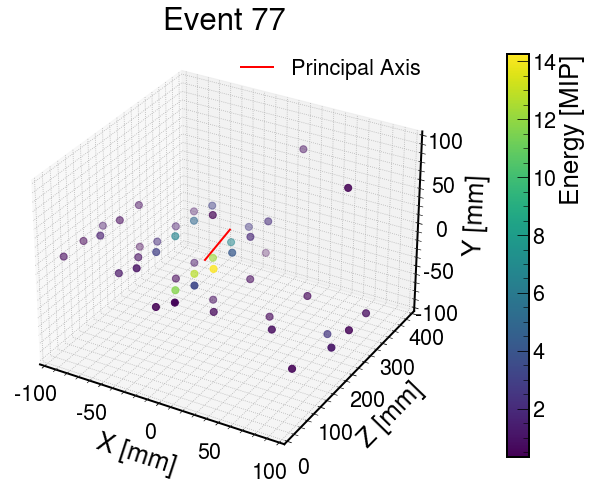

In [114]:
plot_event_3d_with_direction(beam_data, beam_high_indexes[2])

In [115]:
def plot_event_projections(beam_data, evtnum, threshold=0.3):
    positions = beam_data['positions'][:, :3]  # Only x, y, z
    event = beam_data['events'][evtnum]

    mask = event > threshold
    energies = event[mask]
    pos_filtered = positions[mask]

    xs = pos_filtered[:, 0]
    ys = pos_filtered[:, 1]
    zs = pos_filtered[:, 2]

    cog = compute_cog_vector(energies, pos_filtered)
    moment = compute_event_moment_matrix(energies, pos_filtered)
    _, _, principal_axis, _, _ = compute_cluster_orientation(moment)

    # Line length for visibility
    scale = 50
    end = cog + principal_axis * scale
    start = cog - principal_axis * scale

    def plot_energy_projection(x, y, energy, xlabel, ylabel, title, proj_start, proj_end):
        df = pd.DataFrame({'x': x, 'y': y, 'energy': energy})
        grouped = df.groupby(['x', 'y'], as_index=False).sum()

        configure_plotting()
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(grouped['x'], grouped['y'], c=grouped['energy'],
                         cmap='viridis', s=80)
        plt.plot([proj_start[0], proj_end[0]], [proj_start[1], proj_end[1]],
                 color='red', linewidth=2, label='Principal Axis')
        plt.colorbar(sc, label='Energy [MIP]')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Project start/end onto each plane
    plot_energy_projection(xs, ys, energies, 'X [mm]', 'Y [mm]',
                           f'XY Projection - Event {evtnum}',
                           proj_start=start[[0, 1]], proj_end=end[[0, 1]])
    
    plot_energy_projection(xs, zs, energies, 'X [mm]', 'Z [mm]',
                           f'XZ Projection - Event {evtnum}',
                           proj_start=start[[0, 2]], proj_end=end[[0, 2]])
    
    plot_energy_projection(ys, zs, energies, 'Y [mm]', 'Z [mm]',
                           f'YZ Projection - Event {evtnum}',
                           proj_start=start[[1, 2]], proj_end=end[[1, 2]])



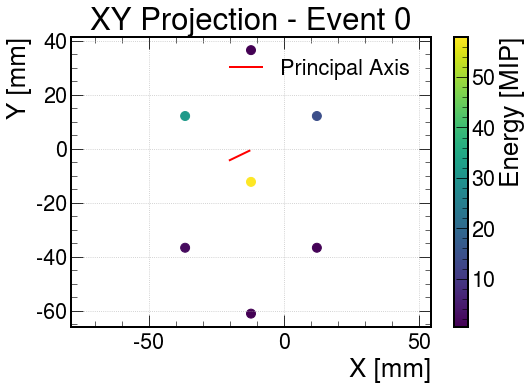

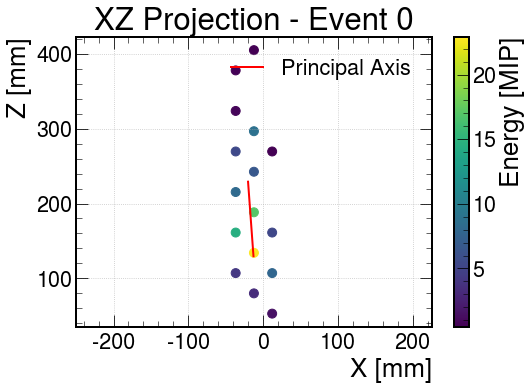

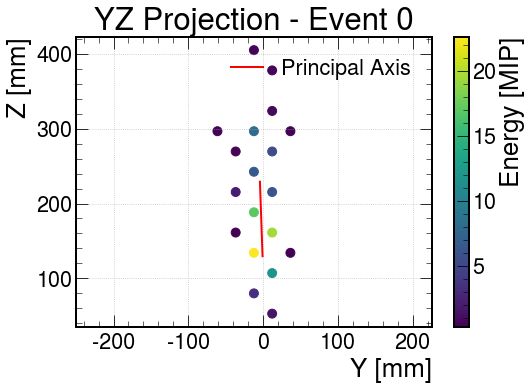

In [116]:
plot_event_projections(sim_data, evtnum=sim_high_indexes[0])

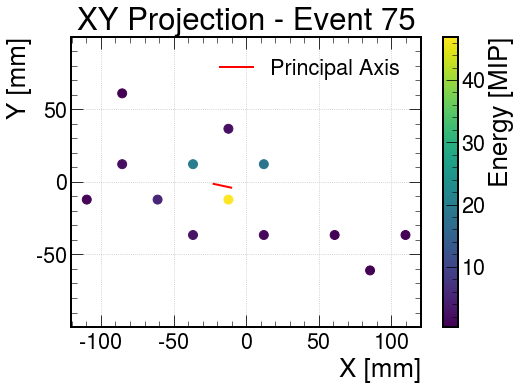

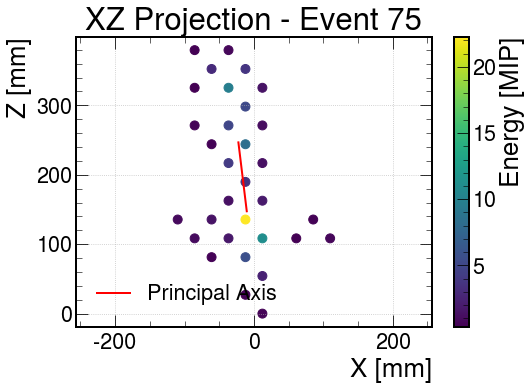

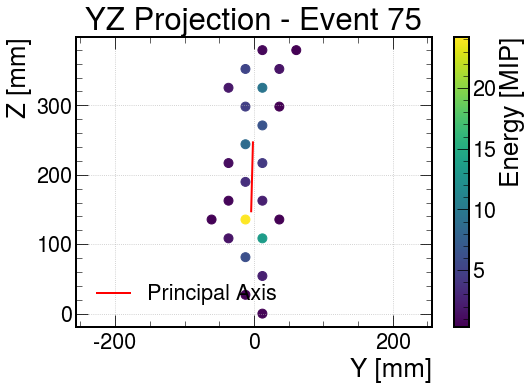

In [117]:
plot_event_projections(beam_data, evtnum=beam_high_indexes[0])